In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn sqlalchemy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import sys
!{sys.executable} -m pip install SQLAlchemy


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sqlalchemy import create_engine


In [4]:

!pip install openpyxl




Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Load the dataset
data = pd.read_csv('OnlineRetail.csv')  # Use read_csv for CSV files

# Display the first few rows
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  12/01/2010 08:26:00       2.55     17850.0  United Kingdom  
1  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
2  12/01/2010 08:26:00       2.75     17850.0  United Kingdom  
3  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
4  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  


In [6]:
# Check the shape of the dataset
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

# Display column names and data types
print(data.info())

# Summary statistics
print(data.describe())


Dataset contains 541909 rows and 8 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   1515

In [7]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Drop rows with missing CustomerID or other essential fields
data = data.dropna(subset=['CustomerID'])

# Optionally, drop rows with negative or zero Quantity or UnitPrice
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]


Description      1454
CustomerID     135080
dtype: int64


In [8]:
# Select relevant columns
data = data[['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']]

# Display remaining columns
print(data.columns)


Index(['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country'], dtype='object')


In [9]:


# Load the dataset
data = pd.read_csv('OnlineRetail.csv')  # or the correct file path

# Check the DataFrame structure and column names
print(data.head())
print(data.columns)

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Create Total Spend feature
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# Define the reference date as the day after the last invoice date
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Check if 'InvoiceNo' exists in the DataFrame
if 'InvoiceNo' in data.columns:
    # RFM Calculation
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalSpend': 'sum'
    }).reset_index()

    rfm.rename(columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'TotalSpend': 'Monetary'
    }, inplace=True)

    print(rfm.head())
else:
    print("Column 'InvoiceNo' not found in the DataFrame.")


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  12/01/2010 08:26:00       2.55     17850.0  United Kingdom  
1  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
2  12/01/2010 08:26:00       2.75     17850.0  United Kingdom  
3  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
4  12/01/2010 08:26:00       3.39     17850.0  United Kingdom  
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
   CustomerID  Recency  Frequency  Monet

In [10]:
# Define a function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Remove outliers for Monetary
rfm = remove_outliers(rfm, 'Monetary')

# Similarly, you can remove outliers for Recency and Frequency if needed


In [11]:
# Features to scale
features = ['Recency', 'Frequency', 'Monetary']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
rfm_scaled = scaler.fit_transform(rfm[features])

# Convert to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=features)

print(rfm_scaled.head())


    Recency  Frequency  Monetary
0  2.210736  -0.449234 -1.050747
1 -0.238759   0.187873  1.157604
2 -0.785260  -0.767788  1.108835
3  2.054593  -0.767788 -0.639855
4 -0.619358   2.417749  0.848168


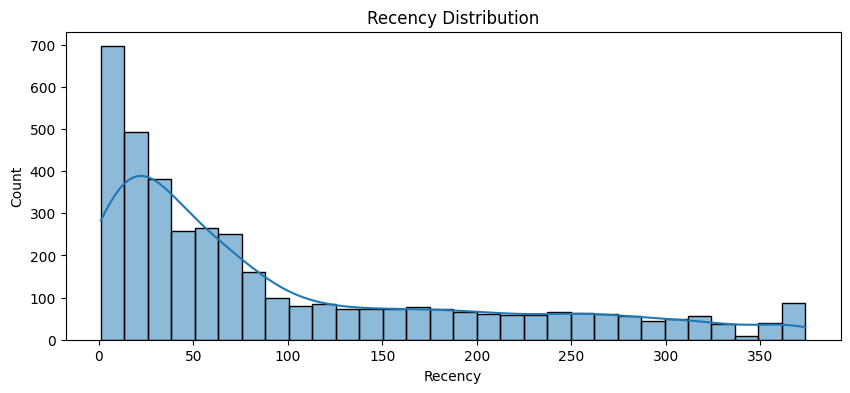

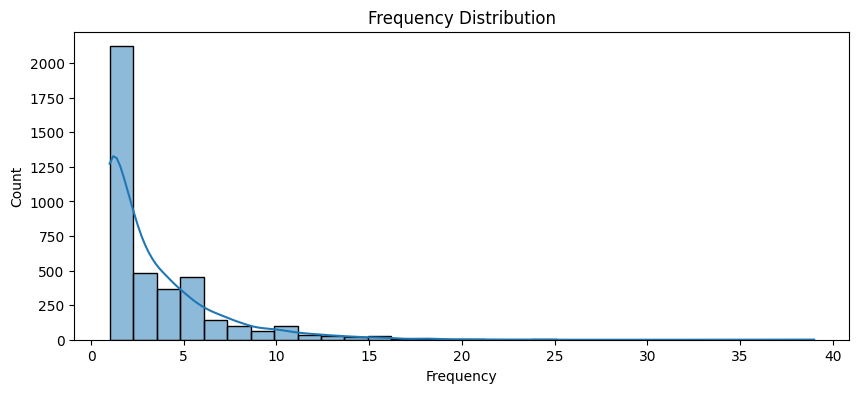

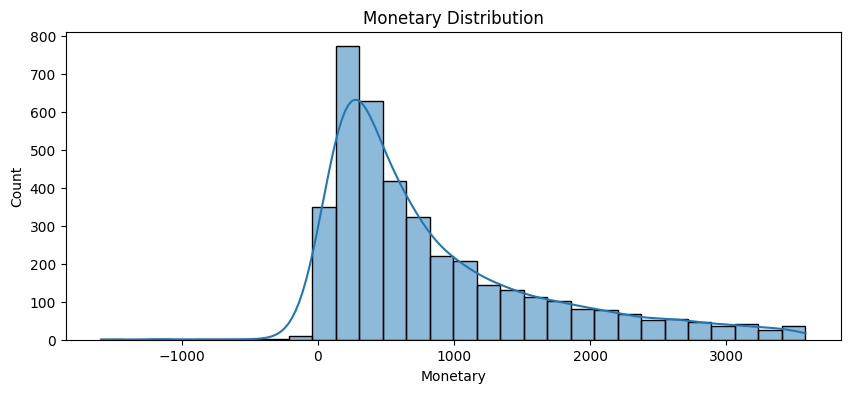

In [12]:
# Recency
plt.figure(figsize=(10,4))
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Recency Distribution')
plt.show()

# Frequency
plt.figure(figsize=(10,4))
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Frequency Distribution')
plt.show()

# Monetary
plt.figure(figsize=(10,4))
sns.histplot(rfm['Monetary'], bins=30, kde=True)
plt.title('Monetary Distribution')
plt.show()


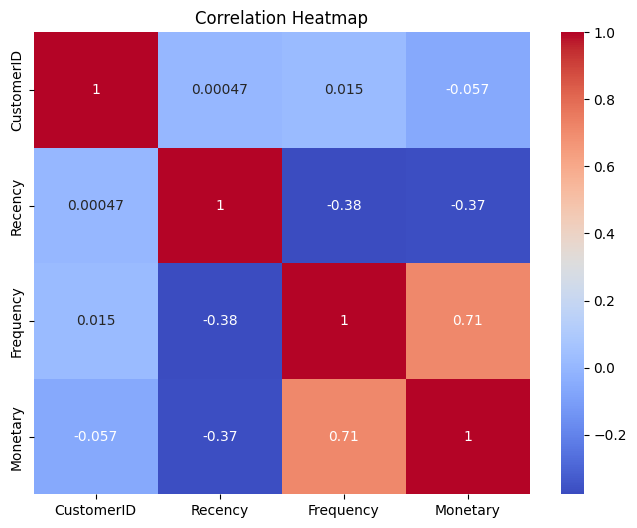

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [14]:
# Average Order Value
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Lifetime
data_sorted = data.sort_values(['CustomerID', 'InvoiceDate'])
first_purchase = data_sorted.groupby('CustomerID')['InvoiceDate'].min().reset_index()
last_purchase = data_sorted.groupby('CustomerID')['InvoiceDate'].max().reset_index()
lifetime = pd.merge(first_purchase, last_purchase, on='CustomerID')
lifetime['Lifetime'] = (lifetime['InvoiceDate_y'] - lifetime['InvoiceDate_x']).dt.days

rfm = pd.merge(rfm, lifetime[['CustomerID', 'Lifetime']], on='CustomerID')

# Scale additional features if needed
features_extended = ['Recency', 'Frequency', 'Monetary', 'AOV', 'Lifetime']
scaler_extended = StandardScaler()
rfm_scaled_extended = scaler_extended.fit_transform(rfm[features_extended])
rfm_scaled_extended = pd.DataFrame(rfm_scaled_extended, columns=features_extended)

print(rfm_scaled_extended.head())


    Recency  Frequency  Monetary       AOV  Lifetime
0  2.210736  -0.449234 -1.050747 -1.184686 -0.930097
1 -0.238759   0.187873  1.157604  0.730043  1.341967
2 -0.785260  -0.767788  1.108835  6.305090 -0.930097
3  2.054593  -0.767788 -0.639855  0.240356 -0.930097
4 -0.619358   2.417749  0.848168 -0.585982  1.164714


C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\skle

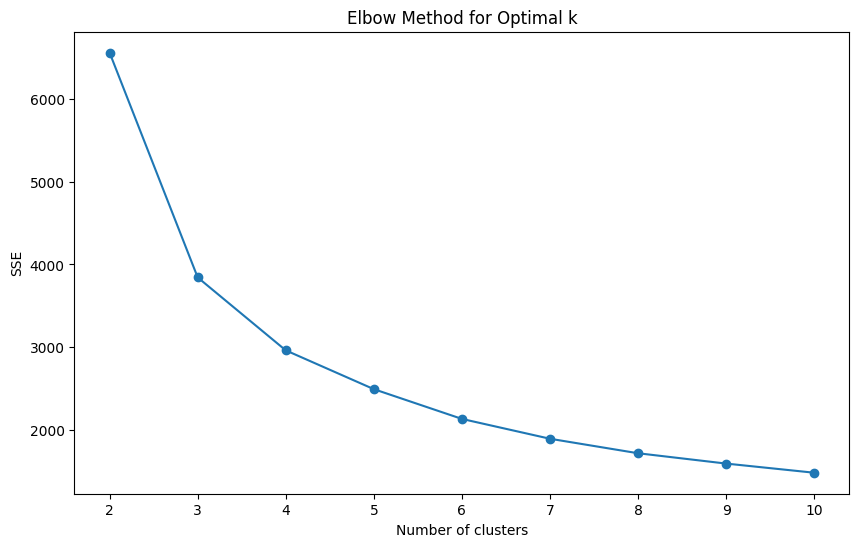

C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\skle

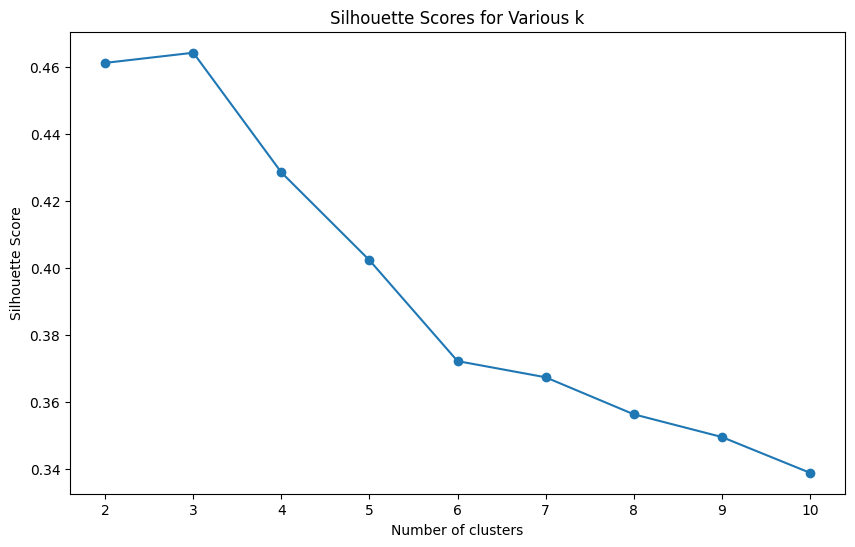

In [15]:
# Elbow Method
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal k")
plt.show()

# Silhouette Score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Various k")
plt.show()


In [16]:
# Initialize KMeans with optimal number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(rfm_scaled)

# Assign clusters to the original dataframe
rfm['Cluster'] = kmeans.labels_

# Display the number of customers in each cluster
print(rfm['Cluster'].value_counts())


Cluster
1    1748
3     959
2     874
0     368
Name: count, dtype: int64


C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


C:\Users\Kavisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


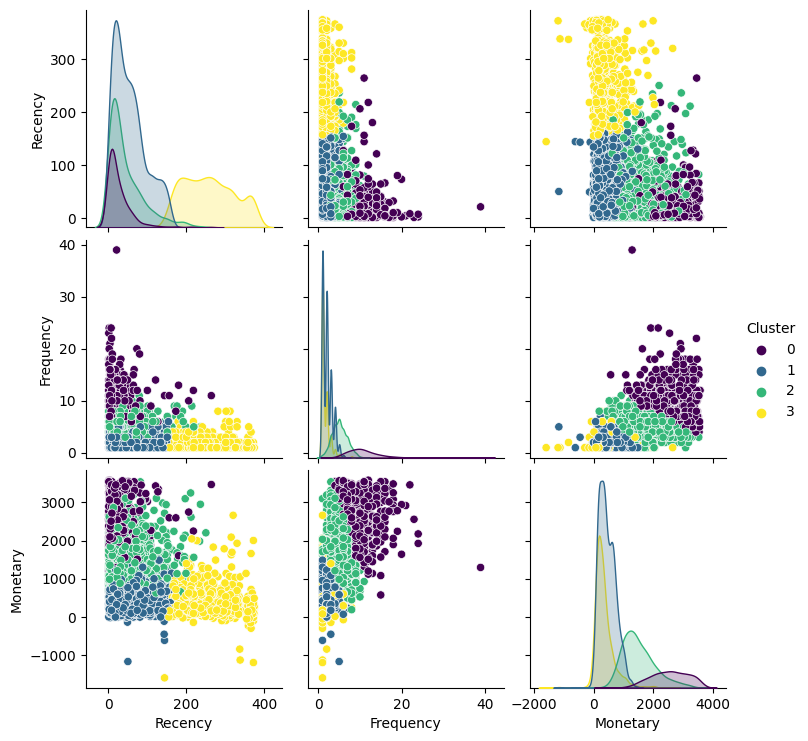

In [17]:
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis')
plt.show()


In [18]:
cluster_profiles = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AOV': 'mean',
    'Lifetime': 'mean'
}).round(1)

print(cluster_profiles)


         Recency  Frequency  Monetary    AOV  Lifetime
Cluster                                               
0           26.8       10.6    2555.0  274.1     277.9
1           54.5        2.1     451.0  253.4      86.8
2           45.3        5.1    1508.9  369.6     206.7
3          258.8        1.6     343.7  240.9      22.1


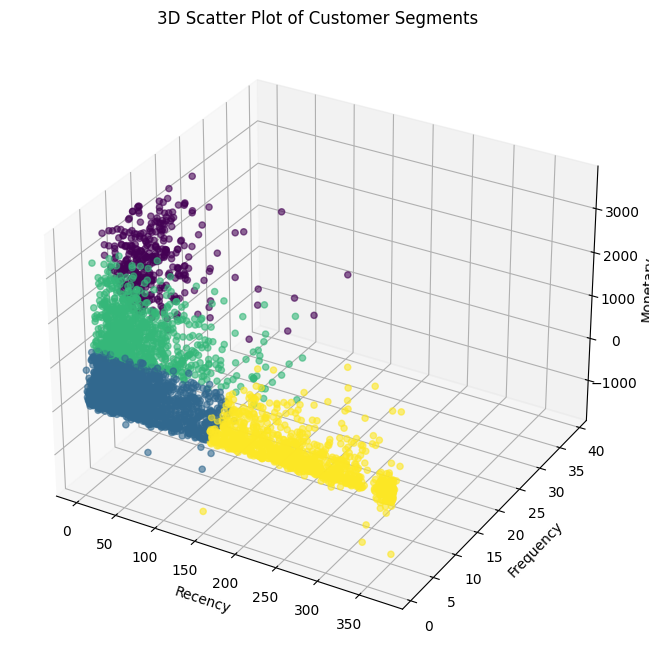

In [19]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], 
           c=rfm['Cluster'], cmap='viridis', marker='o', alpha=0.6)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D Scatter Plot of Customer Segments')
plt.show()


In [20]:
# Create a connection to SQLite database (it will create the database file if it doesn't exist)
engine = create_engine('sqlite:///ecommerce_customer_segmentation.db')

# Store the RFM dataframe with cluster labels into a SQL table
rfm.to_sql('customer_segments', engine, if_exists='replace', index=False)

print("Customer segments have been successfully stored in the database.")


Customer segments have been successfully stored in the database.


In [21]:
# Example: Retrieve all customers in Cluster 0
cluster_0 = pd.read_sql_query("SELECT * FROM customer_segments WHERE Cluster = 0", engine)
print(cluster_0.head())

# Example: Get the number of customers in each cluster
cluster_counts = pd.read_sql_query("SELECT Cluster, COUNT(*) as Count FROM customer_segments GROUP BY Cluster", engine)
print(cluster_counts)


   CustomerID  Recency  Frequency  Monetary         AOV  Lifetime  Cluster
0     12352.0       36         11   1545.41  140.491818       260        0
1     12370.0       51          4   3545.69  886.422500       309        0
2     12388.0       16          6   2780.66  463.443333       311        0
3     12395.0       16         15   2998.28  199.885333       355        0
4     12408.0       33          9   2842.57  315.841111       227        0
   Cluster  Count
0        0    368
1        1   1748
2        2    874
3        3    959
